# [Домашнє завдання до модуля «Вступ до NLP»](https://www.edu.goit.global/learn/25315460/26519706/26524723/homework)

## Dataset: [Email Spam Detection Dataset (classification)](https://www.kaggle.com/datasets/shantanudhakadd/email-spam-detection-dataset-classification)

### Imports & Config

In [131]:
import os, warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import nltk
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

%matplotlib inline


### Load data

In [132]:
file_path = os.path.expanduser("~/Projects/DataSets/GoIT/EmailSpamDetectionDataset/spam.csv")

df = pd.read_csv(file_path, encoding="latin-1")
df = df.rename(columns={"v1": "label", "v2": "text"})
df = df[["label", "text"]]

print(f"Total messages: {df.shape[0]}")
print(df["label"].value_counts())
df.head(5)

Total messages: 5572
label
ham     4825
spam     747
Name: count, dtype: int64


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### EDA

In [133]:
df["num_words"] = df["text"].apply(lambda x: len(x.split()))
print("Average words in ham:", df[df["label"] == "ham"]["num_words"].mean())
print("Average words in spam:", df[df["label"] == "spam"]["num_words"].mean())

Average words in ham: 14.20062176165803
Average words in spam: 23.85140562248996


### Text preprocessing (cleaning, tokenization, stop words removal, lemmatization)

In [134]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df["text_clean"] = df["text"].apply(preprocess_text)

print("Original:", df.loc[2, "text"])
print("After cleaning:", df.loc[2, "text_clean"])

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
After cleaning: free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nickolasz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nickolasz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Splitting the dataset into training and test sets

In [135]:
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df["label_num"],
    test_size=0.2,
    stratify=df["label_num"],
    random_state=42,
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print(f"Spam in training set: {sum(y_train)} ({100 * sum(y_train) / len(y_train):.2f}%)")
print(f"Spam in test set: {sum(y_test)} ({100 * sum(y_test) / len(y_test):.2f}%)")

Train size: 4457 Test size: 1115
Spam in training set: 598 (13.42%)
Spam in test set: 149 (13.36%)


### Building vector representations of text

#### Bag-of-Words

In [136]:
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

print(f"Dimension of BoW matrix (train): {X_train_bow.shape}")
print(f"Example fragment of the vector for the first message:\n {X_train_bow[0, :10].toarray()}")
print(f"Number of unique words (vocabulary size): {len(vectorizer_bow.vocabulary_)}")

Dimension of BoW matrix (train): (4457, 6256)
Example fragment of the vector for the first message:
 [[0 0 0 0 0 0 0 0 0 0]]
Number of unique words (vocabulary size): 6256


#### TF-IDF

In [137]:
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print(f"Dimension of TF-IDF matrix (train): {X_train_tfidf.shape}")
print(f"Example values of TF-IDF for the first 5 words of the first message:\n {X_train_tfidf[0, :5].toarray()}")

Dimension of TF-IDF matrix (train): (4457, 6256)
Example values of TF-IDF for the first 5 words of the first message:
 [[          0           0           0           0           0]]


#### GloVe

In [138]:
glove_path = os.path.expanduser("~/Projects/DataSets/GoIT/EmailSpamDetectionDataset/glove.6B.200d.txt")
embedding_index = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        embedding_index[word] = vector

def text_to_embedding(text):
    words = text.split()
    word_vecs = [embedding_index[w] for w in words if w in embedding_index]
    if len(word_vecs) == 0:
        return np.zeros(200)
    word_vecs = np.array(word_vecs)
    return word_vecs.mean(axis=0)


X_train_glove = np.vstack(X_train.apply(text_to_embedding).values)
X_test_glove = np.vstack(X_test.apply(text_to_embedding).values)

print(f"Dimension of feature matrix GloVe (train): {X_train_glove.shape}")
print(f"Example vector for the first message (first 5 values):\n {X_train_glove[0][:5]}")

Dimension of feature matrix GloVe (train): (4457, 200)
Example vector for the first message (first 5 values):
 [    0.18843     0.20657    -0.17694   0.0070273    -0.15165]


### Models

#### Logistic Regression, Random Forest

In [139]:
model_lr_bow = LogisticRegression(max_iter=1000, random_state=42)
model_lr_bow.fit(X_train_bow, y_train)
y_pred_bow_lr = model_lr_bow.predict(X_test_bow)
y_prob_bow_lr = model_lr_bow.predict_proba(X_test_bow)[:, 1]

acc_bow_lr = accuracy_score(y_test, y_pred_bow_lr)
auc_bow_lr = roc_auc_score(y_test, y_prob_bow_lr)
print(f"Logistic Regression (BoW) - Accuracy: {acc_bow_lr:.4f}, AUC: {auc_bow_lr:.4f}")

Logistic Regression (BoW) - Accuracy: 0.9812, AUC: 0.9838


In [140]:
model_rf_bow = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_bow.fit(X_train_bow, y_train)
y_pred_bow_rf = model_rf_bow.predict(X_test_bow)
y_prob_bow_rf = model_rf_bow.predict_proba(X_test_bow)[:, 1]

acc_bow_rf = accuracy_score(y_test, y_pred_bow_rf)
auc_bow_rf = roc_auc_score(y_test, y_prob_bow_rf)
print(f"Random Forest (BoW) - Accuracy: {acc_bow_rf:.4f}, AUC: {auc_bow_rf:.4f}")

Random Forest (BoW) - Accuracy: 0.9749, AUC: 0.9807


#### TF-IDF

In [141]:
model_lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
model_lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_lr = model_lr_tfidf.predict(X_test_tfidf)
y_prob_tfidf_lr = model_lr_tfidf.predict_proba(X_test_tfidf)[:, 1]

acc_tfidf_lr = accuracy_score(y_test, y_pred_tfidf_lr)
auc_tfidf_lr = roc_auc_score(y_test, y_prob_tfidf_lr)
print(
    f"Logistic Regression (TF-IDF) - Accuracy: {acc_tfidf_lr:.4f}, AUC: {auc_tfidf_lr:.4f}"
)

Logistic Regression (TF-IDF) - Accuracy: 0.9695, AUC: 0.9856


In [142]:
model_rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_rf = model_rf_tfidf.predict(X_test_tfidf)
y_prob_tfidf_rf = model_rf_tfidf.predict_proba(X_test_tfidf)[:, 1]

acc_tfidf_rf = accuracy_score(y_test, y_pred_tfidf_rf)
auc_tfidf_rf = roc_auc_score(y_test, y_prob_tfidf_rf)
print(f"Random Forest (TF-IDF) - Accuracy: {acc_tfidf_rf:.4f}, AUC: {auc_tfidf_rf:.4f}")

Random Forest (TF-IDF) - Accuracy: 0.9776, AUC: 0.9801


#### GloVe

In [143]:
model_lr_glove = LogisticRegression(max_iter=1000, random_state=42)
model_lr_glove.fit(X_train_glove, y_train)
y_pred_glove_lr = model_lr_glove.predict(X_test_glove)
y_prob_glove_lr = model_lr_glove.predict_proba(X_test_glove)[:, 1]

acc_glove_lr = accuracy_score(y_test, y_pred_glove_lr)
auc_glove_lr = roc_auc_score(y_test, y_prob_glove_lr)
print(
    f"Logistic Regression (GloVe) - Accuracy: {acc_glove_lr:.4f}, AUC: {auc_glove_lr:.4f}"
)

Logistic Regression (GloVe) - Accuracy: 0.9471, AUC: 0.9717


In [144]:
model_rf_glove = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_glove.fit(X_train_glove, y_train)
y_pred_glove_rf = model_rf_glove.predict(X_test_glove)
y_prob_glove_rf = model_rf_glove.predict_proba(X_test_glove)[:, 1]

acc_glove_rf = accuracy_score(y_test, y_pred_glove_rf)
auc_glove_rf = roc_auc_score(y_test, y_prob_glove_rf)
print(f"Random Forest (GloVe) - Accuracy: {acc_glove_rf:.4f}, AUC: {auc_glove_rf:.4f}")

Random Forest (GloVe) - Accuracy: 0.9587, AUC: 0.9651


### Plotting model performance comparison

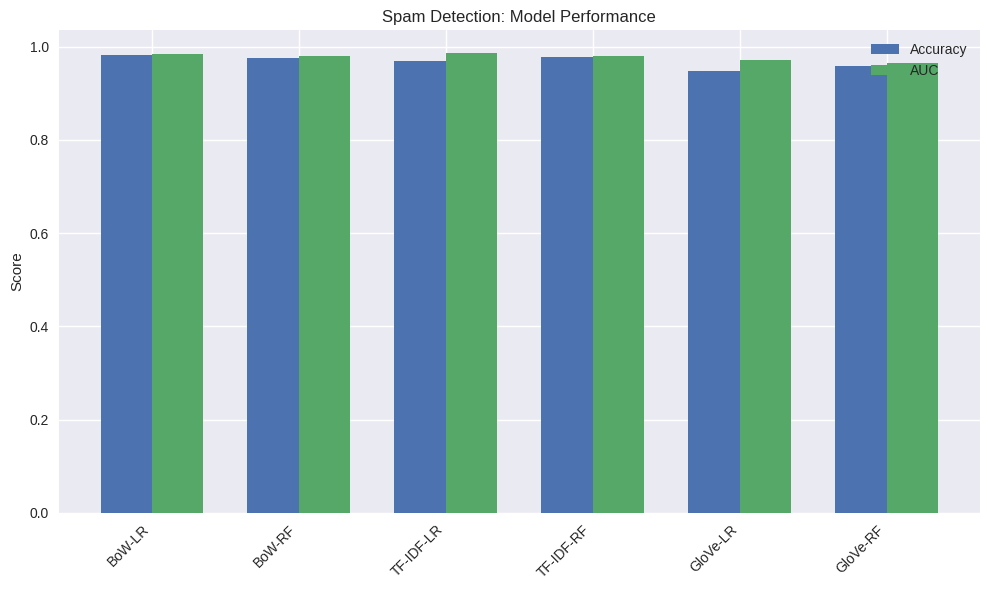

In [ ]:

labels = ['BoW-LR', 'BoW-RF', 'TF-IDF-LR', 'TF-IDF-RF', 'GloVe-LR', 'GloVe-RF']
accuracies = [acc_bow_lr, acc_bow_rf, acc_tfidf_lr, acc_tfidf_rf, acc_glove_lr, acc_glove_rf]
aucs       = [auc_bow_lr, auc_bow_rf, auc_tfidf_lr, auc_tfidf_rf, auc_glove_lr, auc_glove_rf]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, accuracies, width, label='Accuracy')
ax.bar(x + width/2, aucs, width, label='AUC')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Spam Detection: Model Performance')
ax.legend()
plt.tight_layout()
plt.show()

## Conclusion

Для задачі класифікації спам vs ham із текстів повідомлень найкращим підходом виявився векторизація TF-IDF або BoW у поєднанні з логістичною регресією – цей метод дав найвищу точність і AUC. Він перевершує більш складний підхід із середніми GloVe-ембеддингами в даному експерименті. 
Причина – ключові слова грають вирішальну роль у визначенні спаму, і методи на основі частот слів безпосередньо їх фіксують. 
Random Forest теж показав себе добре, але трохи поступився логістичній регресії. 
Отже, простий лінійний алгоритм на розріджених текстових ознаках став найуспішнішим для цього завдання, досягнувши ~97–98% точності на тестових даних
Це демонструє, що навіть базові методи NLP можуть бути надзвичайно ефективними для виявлення спаму.